In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing
import re

from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary

# LyricsLda CLASS

In [6]:
class LyricsLda:
        
    def __init__(self, lyrics_df, preprocessed_corpus):
                
        self.lyrics_df = lyrics_df
        self.lyrics_df_shuffled = None
        self.preprocessed_corpus = preprocessed_corpus
        
        self.coherence_values = None
        self.model = None
        self.topic_corpus = None
        self.descriptors = None
        self.num_topics = None
        self.shuffled_corpus_idxs = None
    
    
    def create_lda_corpus(self, randomize=False, preprocessed_corpus=None, filter_extremes=(100, 0.1)):
        
        if preprocessed_corpus is None:
            corpus = self.preprocessed_corpus  #.copy() # copy necessary to avoid randomizing in place
        
        # randomize in order to guarantee coherent (diversity across genres) dev and eval datasets when choosing number of topics
        if randomize:
            print("Randomizing corpus ...")
            corpus = np.array(corpus)
            shuffled_idxs = np.arange(corpus.shape[0])
            random.shuffle(shuffled_idxs)
            self.shuffled_corpus_idxs = shuffled_idxs
            
            # RESHUFFLE CORPUS AND DF ACCORDINGLY
            corpus = corpus[shuffled_idxs].tolist()
            self.lyrics_df_shuffled = self.lyrics_df.iloc[shuffled_idxs, :].reset_index(drop=True)
            
        print("Creating dictionary ...")
        # read in instances and create Dictionary object w information about frequencies etc. 
        dictionary = Dictionary(corpus)
        # get rid of words that are too rare or too frequent
        dictionary.filter_extremes(no_below=filter_extremes[0], no_above=filter_extremes[1])
        
        #replace words by their numerical IDs and their frequency
        print("Creating model corpus ...", flush=True)
        lda_corpus = [dictionary.doc2bow(text) for text in tqdm(corpus)]
        # learn TFIDF values from corpus and transform raw frequencies into TFIDF
        tfidf_model = TfidfModel(lda_corpus)
        model_corpus = tfidf_model[lda_corpus]
        
        return corpus, model_corpus, dictionary
    
    
    def choose_num_topics(self, shuffled_corpus, model_corpus, dictionary, topics_range=(1, 20), dev_size=10000, eval_size=5000, alpha=0.5):
        
        coherence_values = []
        model_list = []

        dev_size = dev_size
        eval_size = eval_size
        
        print("Choosing topics ...", flush=True)
        for num_topics in tqdm(range(topics_range[0], topics_range[1])):
            model = LdaMulticore(corpus=model_corpus[:dev_size], id2word=dictionary, num_topics=num_topics, alpha=alpha)
            model_list.append(model)
            coherencemodel_umass = CoherenceModel(model=model, 
                                                  texts=shuffled_corpus[dev_size:dev_size+eval_size], 
                                                  dictionary=dictionary, 
                                                  coherence='u_mass')

            coherencemodel_cv = CoherenceModel(model=model, 
                                               texts=shuffled_corpus[dev_size:dev_size+eval_size], 
                                               dictionary=dictionary, 
                                               coherence='c_v')

            umass_score = coherencemodel_umass.get_coherence()
            cv_score = coherencemodel_cv.get_coherence()

            coherence_values.append((num_topics, umass_score, cv_score))
        
        self.coherence_values = coherence_values
        
        for coherence_value in coherence_values:
            print(coherence_value)
        
        return coherence_values
    
    
    def plot_coherence_values(self, coherence_values=None, topics_range=(1, 20), fig_size=(10, 5)):
        
        if coherence_values is None:
            coherence_values = self.coherence_values

        scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=fig_size)
        scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(topics_range[0], topics_range[1]))
        scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(topics_range[0], topics_range[1]))
        plt.show()
        
        return 
    
    
    def fit_transform(self, num_topics, model_corpus=None, dictionary=None, iterations=50, num_passes=10, num_updates=200, alpha=0.5):
        
        self.num_topics = num_topics
        
        # [1:] -> only need model corpus and dictionary
        if model_corpus is None:
            model_corpus, model_corpus_dict = self.create_lda_corpus(randomize=False)[1:]
            if dictionary is None:
                dictionary = model_corpus_dict
        
        # find chunksize to make about 200 updates
        num_passes = num_passes
        chunk_size = len(model_corpus) * num_passes/num_updates

        # fit
        model = LdaMulticore(num_topics=self.num_topics, # number of topics
                             corpus=model_corpus, # what to train on 
                             id2word=dictionary, # mapping from IDs to words
                             workers=min(10, multiprocessing.cpu_count()-1), # choose 10 cores, or whatever computer has
                             iterations=iterations, # maximum number of times the model loops over each document
                             passes=num_passes, # make this many passes over data
                             chunksize=chunk_size, # update after this many instances
                             alpha=alpha
                            )
        self.model = model
        
        # transform the data into topic distributions
        topic_corpus = model[model_corpus]
        self.topic_corpus = topic_corpus
        
        return topic_corpus
    
    
    def print_topics(self, num_topics=None, num_words=5):
        
        if num_topics is None:
            num_topics = self.num_topics
        
        # get the topic descritions
        topic_sep = re.compile(r"0\.[0-9]{3}\*") # getting rid of useless formatting
        # extract a list of tuples with topic number and descriptors from the model
        model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                        self.model.print_topics(num_topics=num_topics, num_words=num_words)]

        descriptors = []
        for i, m in model_topics:
            print(i+1, ", ".join(m[:num_words]))
            descriptors.append(", ".join(m[:num_words]).replace('"', ''))
        
        self.descriptors = descriptors
        
        return
        
    
    def period_column(self, lyrics_df=None):
        
        input_df = lyrics_df
        
        if lyrics_df is None:
            lyrics_df = self.lyrics_df
        
        def year_to_period(year):
            if int(year) < 1970:
                return "<70s"
            elif int(year) < 1980:
                return "70s-80s"
            elif int(year) < 1990:
                return "80s-90s"
            elif int(year) < 2000:
                return "90s-2000"
            elif int(year) < 2010:
                return "2000-2010"
            else:
                return ">=2010"
        
        lyrics_df.loc[:, "period"] = lyrics_df.year.apply(lambda year: year_to_period(year))
        
        if input_df is None:
            self.lyrics = lyrics_df
        else:
            self.lyrics_df_shuffled = lyrics_df
        
        return lyrics_df
    
    
    def aggregate_topics(self, target_category="genre", aggregate_period=False, topic_corpus=None, descriptors=None, limit=None):
        
        if topic_corpus is None:
            topic_corpus = self.topic_corpus
        if descriptors is None:
            descriptors = self.descriptors
        if limit is None:
            limit = self.lyrics_df.shape[0]
        
        target_category = target_category
        
        print(f"Aggregating topics by {target_category} ...", flush=True)
        # get a list of all the topic scores for each document
        scores = [[t[1] for t in topic_corpus[entry]] for entry in tqdm(range(limit))]
        # turn that into a data frame with N rows and K columns, each with the score of the corresponding topic
        topic_distros = pd.DataFrame(data=scores, columns=descriptors)
        # add the review category of each document (so we can aggregate)
        topic_distros[target_category] = self.lyrics_df[target_category][:limit]
        if aggregate_period:
            self.period_column()
            topic_distros["period"] = self.lyrics_df["period"][:limit]
        
        return topic_distros
    
    
    def plot_aggregated_topics(self, topic_distros, target_category="genre", aggregate_period=False, descriptors=None, include_subcategories=None, fig_size=(10, 5)):
        
        if descriptors is None:
            descriptors = self.descriptors
        if include_subcategories is None:
            include_subcategories = self.lyrics_df.loc[:, target_category].unique()
        num_subcategories = len(include_subcategories)
        
        # aggregate topics by categories
        aggregate_by_category = topic_distros[topic_distros[target_category].isin(include_subcategories)]
        if aggregate_period:
            aggregate_by_category = aggregate_by_category.groupby([target_category, "period"]).mean()
        else:
            aggregate_by_category = aggregate_by_category.groupby(target_category).mean()

        # plot the graph
        if (num_subcategories == 1):
            subcategory = include_subcategories[0]
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fig_size)
            if aggregate_period:
                ordered_periods = [period for period in ["<70s", "70s-80s", "80s-90s", "90s-2000", "2000-2010", ">=2010"]\
                            if period in aggregate_by_category.loc[subcategory, descriptors].index]
                aggregate_by_category.loc[subcategory, descriptors].loc[ordered_periods, :].plot.bar(ax=ax)
            else:
                aggregate_by_category[descriptors].plot.bar(ax=ax)

            handles, labels = ax.get_legend_handles_labels()
            labels = [" ".join(topic_words.split()[:5]) for topic_words in labels]
            plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1.0, 0.5))
            ax.set_title(subcategory, fontdict={'fontsize': 12, 'fontweight':20})
            plt.show()
        else:
            print("Plotting for each group ...", flush=True)
            fig, ax = plt.subplots(nrows=num_subcategories, ncols=1, figsize=fig_size)#(fig_size[0]*num_subcategories, fig_size[1]*num_subcategories))
            for idx, subcategory in enumerate(include_subcategories):
                # sort periods to print them in order
                ordered_periods = [period for period in ["<70s", "70s-80s", "80s-90s", "90s-2000", "2000-2010", ">=2010"]\
                                   if period in aggregate_by_category.loc[subcategory, descriptors].index]
                aggregate_by_category.loc[subcategory, descriptors].loc[ordered_periods, :].plot.bar(ax=ax[idx])
                ax[idx].get_legend().remove()
                ax[idx].set_title(subcategory, fontdict={'fontsize': 12, 'fontweight':20})

            handles, labels = ax[idx].get_legend_handles_labels()
            labels = [" ".join(topic_words.split()[:5]) for topic_words in labels]
            fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.15, 0.5))
            fig.tight_layout(pad=3)
            plt.show()  
        
        return   

# LyricsAuthorLda CLASS

In [3]:
class LyricsAuthorLda(LyricsLda):
    
    
    def __init__(self, lyrics_df, preprocessed_corpus, authors=["genre", "period"]):
        
        super().__init__(lyrics_df=lyrics_df, preprocessed_corpus=preprocessed_corpus)
        
        self.author2doc = None
        self.author_topic_distros = None
        self.authors = authors
    
    
    def create_author2doc(self, lyrics_df=None):
        
        if lyrics_df is None:
            lyrics_df = self.lyrics_df
        
        lyrics_df = self.period_column()
        
        self.author2doc = defaultdict(list)
        for author in self.authors:
            for idx, sub_author in enumerate(lyrics_df.loc[:, author]):
                self.author2doc[sub_author].append(idx)
        return
    
    
    def choose_num_topics(self, shuffled_corpus, model_corpus, dictionary, topics_range=(1, 20), dev_size=10000, eval_size=5000, alpha=0.5):

        coherence_values = []
        author_model_list = []
        
        print("Creating dev_author2doc ...", flush=True)
        if self.lyrics_df_shuffled is None:
            dev_author2doc = {author: [idx for idx in idxs if idx < dev_size] for author, idxs in self.author2doc.items()}
            dev_author2doc = {author: idxs for author, idxs in self.author2doc.items() if len(idxs) != 0}
        else:
            lyrics_df_shuffled = self.period_column(lyrics_df=self.lyrics_df_shuffled)
            dev_author2doc = defaultdict(list)
            for author in self.authors:
                for idx, sub_author in enumerate(self.lyrics_df_shuffled.loc[:, author][:dev_size]):
                    dev_author2doc[sub_author].append(idx)

        print("Choosing topics ...", flush=True)
        for num_topics in tqdm(list(range(topics_range[0], topics_range[1]))):
            
            author_model = AuthorTopicModel(corpus=list(model_corpus[:dev_size]), 
                                    author2doc=dev_author2doc, 
                                    id2word=dictionary, 
                                    num_topics=num_topics,
                                    alpha=alpha
                                    )
            author_model_list.append(author_model)
            
            coherencemodel_umass = CoherenceModel(model=author_model, 
                                                  texts=shuffled_corpus[dev_size:dev_size+eval_size], 
                                                  dictionary=dictionary, 
                                                  coherence='u_mass')

            coherencemodel_cv = CoherenceModel(model=author_model, 
                                               texts=shuffled_corpus[dev_size:dev_size+eval_size], 
                                               dictionary=dictionary, 
                                               coherence='c_v')

            umass_score = coherencemodel_umass.get_coherence()
            cv_score = coherencemodel_cv.get_coherence()

            coherence_values.append((num_topics, umass_score, cv_score))

        self.coherence_values = coherence_values

        for coherence_value in coherence_values:
            print(coherence_value)

        return coherence_values
    
    
    def fit_transform(self, num_topics, model_corpus=None, dictionary=None, num_passes=10, num_updates=200, alpha=0.5):
        
        self.num_topics = num_topics
        
        # [1:] -> only need model corpus and dictionary
        if model_corpus is None:
            model_corpus, model_corpus_dict = self.create_lda_corpus(randomize=False)[1:]
            if dictionary is None:
                dictionary = model_corpus_dict
        
        # find chunksize to make about 200 updates
        num_passes = num_passes
        chunk_size = len(model_corpus) * num_passes/num_updates

        # fit
        with temporary_file("serialized") as s_path:
            author_model = AuthorTopicModel(
                                    model_corpus,
                                    author2doc=self.author2doc,
                                    id2word=dictionary,
                                    num_topics=num_topics,
                                    passes=num_passes,
                                    chunksize=chunk_size,
                                    alpha=alpha,
                                    serialized=True,
                                    serialization_path=s_path,
                                    )    
            author_model.update(model_corpus, self.author2doc)

        self.model = author_model
        
        return 

    
    def aggregate_topics(self):
        
        self.author_topic_distros = {author: [elem[1] for elem in self.model.get_author_topics(author)] 
                                     for author in self.model.id2author.values()
                                    }
        
        return self.author_topic_distros
    
    
    def plot_aggregated_topics(self, author_topic_distros=None, include_genres=None, fig_size=(10, 5)):
        
        if author_topic_distros is None:
            author_topic_distros = self.author_topic_distros
        
        if include_genres is None:
            include_genres = self.lyrics_df.genre.unique()
        num_genres = len(include_genres)
           
        genre_period_df = pd.DataFrame.from_dict(author_topic_distros)
        
        fig, ax = plt.subplots(nrows=num_genres, ncols=1, figsize=fig_size)
        if num_genres == 1:
            genre = include_genres[0]
            columns = f"{genre}_<70s {genre}_70s-80s {genre}_80s-90s {genre}_90s-2000 {genre}_2000-2010 {genre}_>2010".split()
            genre_period_df.loc[:, columns].T.plot.bar(ax=ax)
        else:
            print("Plotting for each genre ...", flush=True)
            for idx, genre in tqdm(enumerate(include_genres)):
                columns = f"{genre}_<70s {genre}_70s-80s {genre}_80s-90s {genre}_90s-2000 {genre}_2000-2010 {genre}_>2010".split()
                genre_period_df.loc[:, columns].T.plot.bar(ax=ax[idx])
                plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        
        plt.show()
        
        return

### Load data 

In [2]:
lyrics_df = pd.read_csv('/Users/lucamasserano/Desktop/BOCCONI/nlp/final_project/lyrics_project/data/lyrics_cleaned.csv')
lyrics_df.shape

(43844, 7)

In [20]:
# token.lemma in trimmed_corpus if and only if token.pos in ['NOUN', 'VERB', 'ADJ', 'ADV', 'INTJ', 'X']
with open('./data/trimmed_corpus.pickle', 'rb') as pickled_object:
    trimmed_corpus = pickle.load(pickled_object)
len(trimmed_corpus)

43844

In [21]:
trimmed_corpus[100]

['appreciate',
 'when',
 'young',
 'mama',
 'beef',
 'year',
 'old',
 'kick',
 'street',
 'back',
 'time',
 'never',
 'think',
 'see',
 'face',
 'woman',
 'alive',
 'could',
 'take',
 'mama',
 'place',
 'suspend',
 'school',
 'scare',
 'home',
 'fool',
 'big',
 'boy',
 'breakin',
 'rule',
 'shed',
 'tear',
 'baby',
 'sister',
 'year',
 'poor',
 'other',
 'little',
 'kid',
 'even',
 'different',
 'daddy',
 'same',
 'drama',
 'when',
 'thing',
 'go',
 'wrong',
 'blame',
 'reminisce',
 'stress',
 'cause',
 'hell',
 'huggin',
 'mama',
 'jail',
 'cell',
 'think',
 'elementary',
 'hey',
 'see',
 'penitentiary',
 'day',
 'police',
 'right',
 'mama',
 'catch',
 'put',
 'whoopin',
 'backside',
 'even',
 'crack',
 'fiend',
 'mama',
 'always',
 'black',
 'queen',
 'finally',
 'understand',
 'woman',
 'easy',
 'tryin',
 'raise',
 'man',
 'always',
 'commit',
 'poor',
 'single',
 'mother',
 'welfare',
 'tell',
 'how',
 'way',
 'can',
 'pay',
 'back',
 'plan',
 'show',
 'understand',
 'appreciate',


# LDA 

### Choose number of topics and fit LDA model 

In [22]:
lyrics_lda = LyricsLda(lyrics_df=lyrics_df, preprocessed_corpus=trimmed_corpus)

In [23]:
shuffled_corpus, lda_corpus, dictionary = lyrics_lda.create_lda_corpus(randomize=True, filter_extremes=(100, 0.5))

Randomizing corpus ...
Creating dictionary ...
Creating model corpus ...


100%|██████████| 43844/43844 [00:04<00:00, 10012.09it/s]


In [24]:
print(dictionary)

Dictionary(2837 unique tokens: ['ace', 'act', 'affair', 'again', 'age']...)


In [25]:
coherence_values = lyrics_lda.choose_num_topics(shuffled_corpus=shuffled_corpus, 
                                                model_corpus=lda_corpus, dictionary=dictionary, topics_range=(5, 15), alpha=0.1)

Choosing topics ...


100%|██████████| 10/10 [03:23<00:00, 21.06s/it]

(5, -0.914060718404409, 0.3295790365890756)
(6, -0.9189080049539138, 0.32667122669732196)
(7, -0.9346524060488409, 0.33178352848909126)
(8, -0.9599265587367461, 0.33525819498207243)
(9, -0.989561612040592, 0.32497796804923673)
(10, -0.9979615540482742, 0.32801035516636623)
(11, -0.9890528138533218, 0.3249204014084702)
(12, -1.011343603904081, 0.32625551270973013)
(13, -1.0021751398759526, 0.32875516321747394)
(14, -1.0428046046357125, 0.3234765268637779)


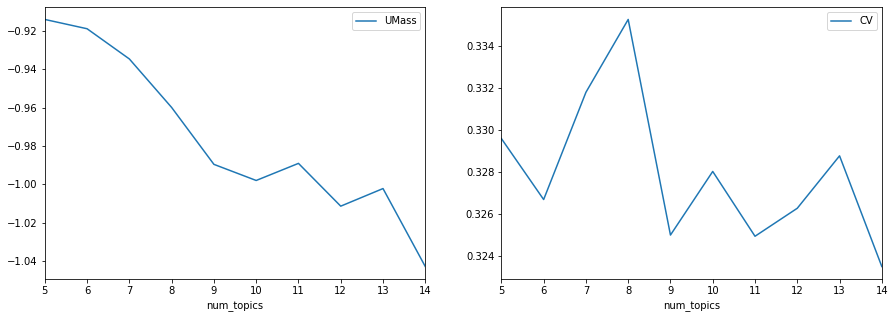

In [26]:
lyrics_lda.plot_coherence_values(fig_size=(15,5), topics_range=(5, 15))

In [30]:
topic_corpus = lyrics_lda.fit_transform(num_topics=8, iterations=100, alpha=0.1)

Creating dictionary ...
Creating model corpus ...


100%|██████████| 43844/43844 [00:04<00:00, 10737.14it/s]


In [31]:
lyrics_lda.print_topics(num_topics=8, num_words=10)

1 "sun", "sky", "sing", "rain", "shine", "wind", "fly", "sea", "star", "blue"
2 "goodbye", "forever", "miss", "sorry", "hurt", "tear", "together", "inside", "alive", "pain"
3 "whoa", "roll", "ride", "town", "rock", "hey", "burn", "fire", "drink", "tonight"
4 "ooh", "tonight", "dance", "feeling", "anymore", "enough", "care", "hurt", "touch", "hey"
5 "feat", "daddy", "mama", "gun", "mother", "hey", "woman", "son", "pretty", "poor"
6 "bitch", "nigga", "gon", "ass", "hit", "niggas", "hey", "hoe", "pussy", "tryna"
7 "soul", "free", "save", "praise", "fear", "lift", "glory", "power", "rise", "faith"
8 "hey", "please", "alright", "beautiful", "else", "woman", "remember", "lonely", "sometimes", "wrong"


#### Aggregate by genre and period

In [32]:
topic_distros_genre_period = lyrics_lda.aggregate_topics(aggregate_period=True)

Aggregating topics by genre ...


100%|██████████| 43844/43844 [00:45<00:00, 972.78it/s] 


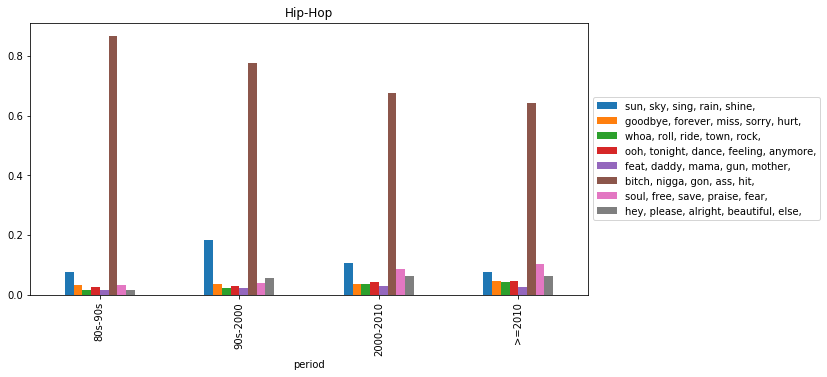

In [35]:
lyrics_lda.plot_aggregated_topics(topic_distros=topic_distros_genre_period, aggregate_period=True, 
                                  include_subcategories=["Hip-Hop"], fig_size=(10, 5))

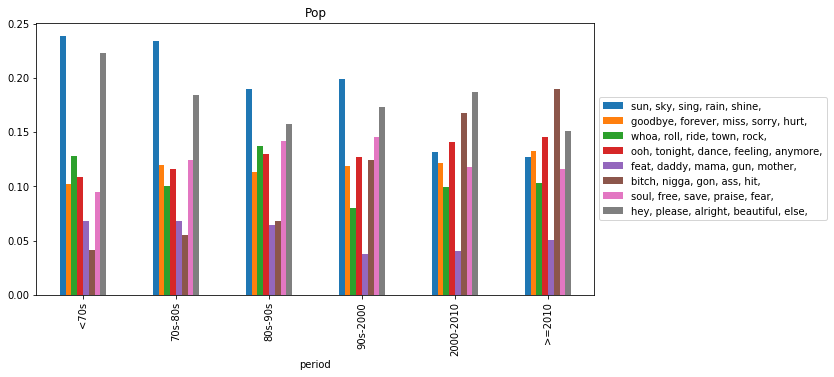

In [36]:
lyrics_lda.plot_aggregated_topics(topic_distros=topic_distros_genre_period, aggregate_period=True, 
                                  include_subcategories=["Pop"], fig_size=(10, 5))

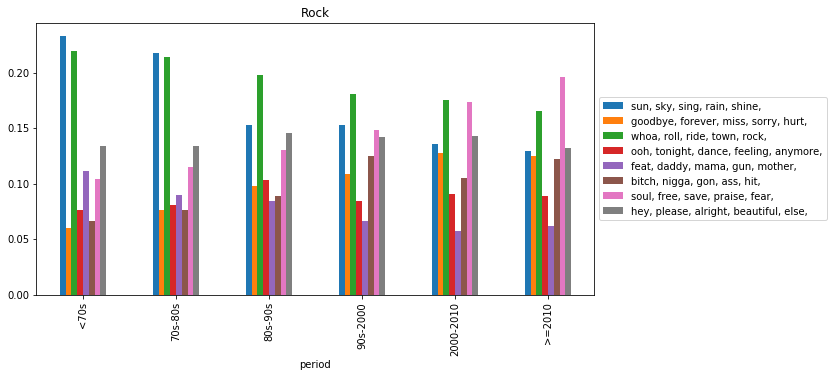

In [37]:
lyrics_lda.plot_aggregated_topics(topic_distros=topic_distros_genre_period, aggregate_period=True, 
                                  include_subcategories=["Rock"], fig_size=(10, 5))

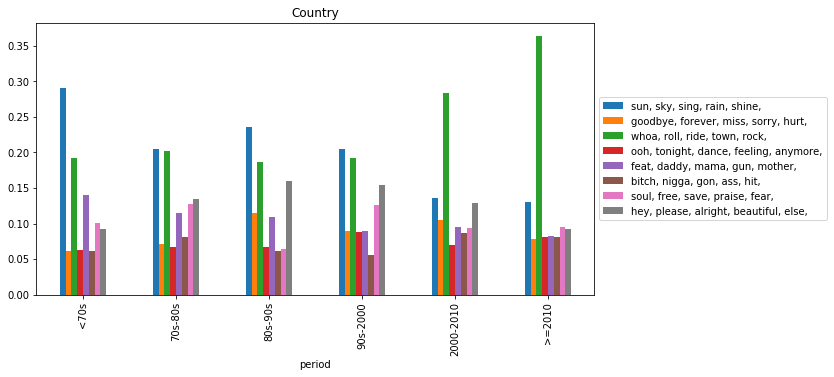

In [38]:
lyrics_lda.plot_aggregated_topics(topic_distros=topic_distros_genre_period, aggregate_period=True, 
                                  include_subcategories=["Country"], fig_size=(10, 5))

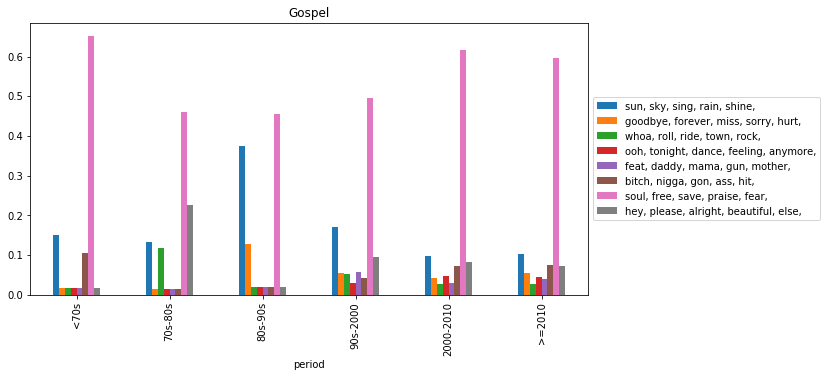

In [39]:
lyrics_lda.plot_aggregated_topics(topic_distros=topic_distros_genre_period, aggregate_period=True, 
                                  include_subcategories=["Gospel"], fig_size=(10, 5))

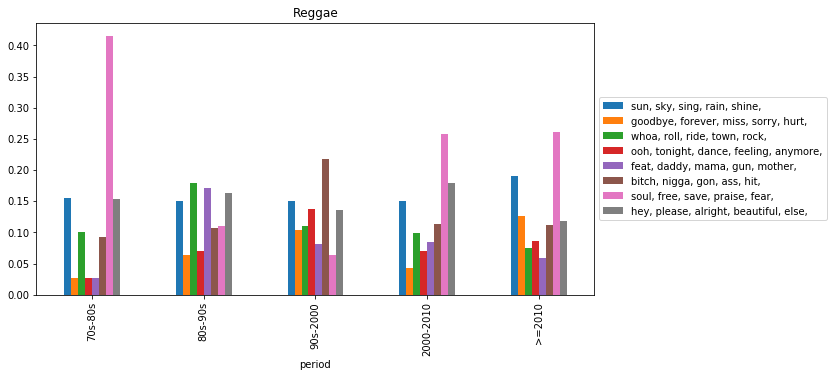

In [40]:
lyrics_lda.plot_aggregated_topics(topic_distros=topic_distros_genre_period, aggregate_period=True, 
                                  include_subcategories=["Reggae"], fig_size=(10, 5))

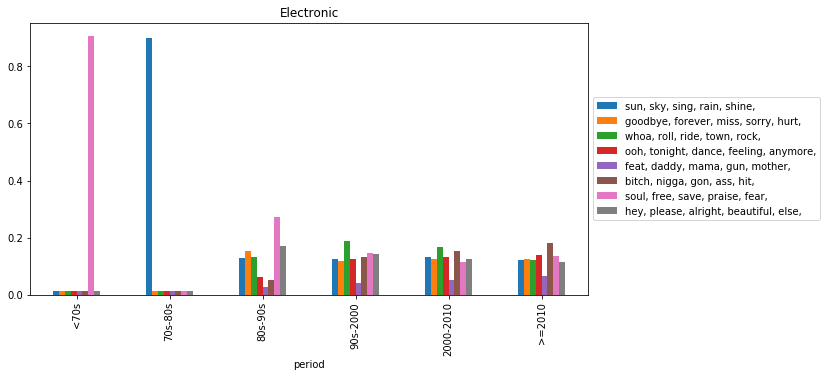

In [41]:
lyrics_lda.plot_aggregated_topics(topic_distros=topic_distros_genre_period, aggregate_period=True, 
                                  include_subcategories=["Electronic"], fig_size=(10, 5))

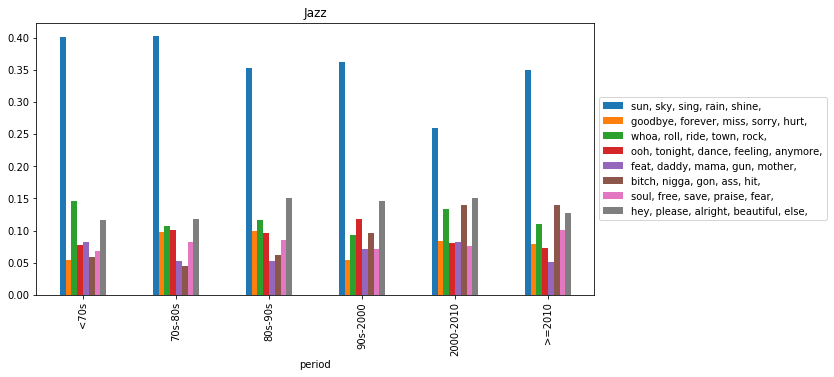

In [42]:
lyrics_lda.plot_aggregated_topics(topic_distros=topic_distros_genre_period, aggregate_period=True, 
                                  include_subcategories=["Jazz"], fig_size=(10, 5))

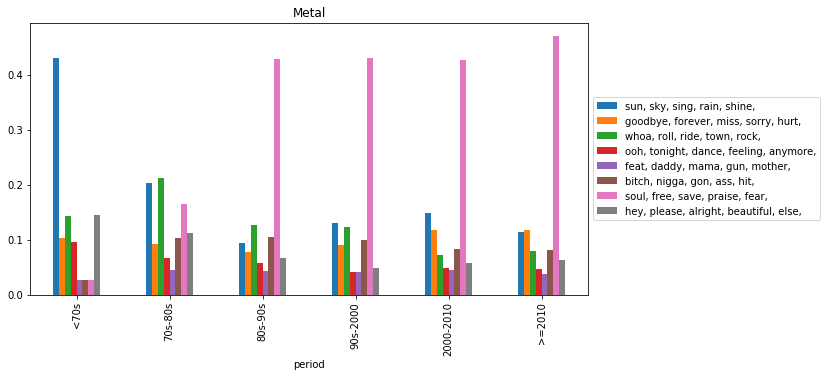

In [43]:
lyrics_lda.plot_aggregated_topics(topic_distros=topic_distros_genre_period, aggregate_period=True, 
                                  include_subcategories=["Metal"], fig_size=(10, 5))

# AUTHOR LDA

In [8]:
import numpy as np
from collections import defaultdict

from gensim.models import AuthorTopicModel
from gensim.test.utils import temporary_file

### Analysis 

In [9]:
lyrics_author_lda = LyricsAuthorLda(lyrics_df=lyrics_df, preprocessed_corpus=trimmed_corpus)

In [10]:
shuffled_corpus, model_corpus, dictionary = lyrics_author_lda.create_lda_corpus(randomize=True)

Randomizing corpus ...
Creating dictionary ...
Creating model corpus ...


100%|██████████| 43844/43844 [00:03<00:00, 12547.47it/s]


In [11]:
print(dictionary, flush=True)

Dictionary(2621 unique tokens: ['album', 'almost', 'bear', 'beat', 'bell']...)


In [12]:
lyrics_author_lda.create_author2doc()

In [13]:
lyrics_author_lda.author2doc.keys()

dict_keys(['Hip-Hop', 'Rock', 'Pop', 'Folk', 'Electronic', 'Reggae', 'Other', 'Metal', 'Gospel', 'Jazz', 'Indie', 'Country', 'R&B', '>=2010', '2000-2010', '90s-2000', '70s-80s', '80s-90s', '<70s'])

In [14]:
coherence_values = lyrics_author_lda.choose_num_topics(shuffled_corpus=shuffled_corpus, 
                                                       model_corpus=model_corpus, 
                                                       dictionary=dictionary, 
                                                       topics_range=(1, 20))

Creating dev_author2doc ...
Choosing topics ...


100%|██████████| 19/19 [03:27<00:00, 11.33s/it]


(1, -5.3055697991473965, 0.3320579746931216)
(2, -5.305063173013155, 0.3320579746931216)
(3, -5.2766287168253845, 0.3320579746931215)
(4, -5.288721600082803, 0.33205797469312154)
(5, -5.286913134489784, 0.3320579746931216)
(6, -5.2905696457107885, 0.33205797469312154)
(7, -5.287370976653695, 0.3320579746931216)
(8, -5.288351759498709, 0.3320579746931215)
(9, -5.292996378814071, 0.3320579746931216)
(10, -5.290728049940874, 0.3320579746931216)
(11, -5.294295733957761, 0.33205797469312154)
(12, -5.287467045495163, 0.3320579746931216)
(13, -5.29517039544468, 0.3320579746931216)
(14, -5.29269293424318, 0.3320579746931216)
(15, -5.2999554398530755, 0.33205797469312154)
(16, -5.301850405801792, 0.33205797469312154)
(17, -5.271904930346189, 0.33205797469312154)
(18, -5.279727126825594, 0.3320579746931216)
(19, -5.277044594761995, 0.3320579746931216)


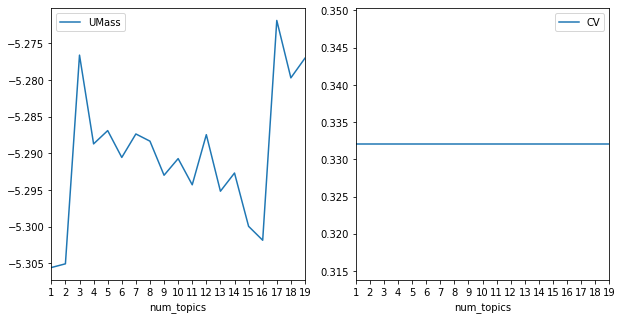

In [15]:
lyrics_author_lda.plot_coherence_values(topics_range=(1, 20))

In [16]:
topic_corpus = lyrics_author_lda.fit_transform(num_topics=10)

Creating dictionary ...
Creating model corpus ...


100%|██████████| 43844/43844 [00:03<00:00, 13684.05it/s]


In [17]:
lyrics_author_lda.print_topics()

1 "lift", "body", "woman", "arm", "gimme"
2 "woman", "crying", "noise", "body", "arm"
3 "reign", "depend", "respect", "body", "woman"
4 "closer", "ooh", "body", "woman", "arm"
5 "daily", "most", "confusion", "game", "body"
6 "tick", "click", "til", "gain", "roof"
7 "anymore", "sweet", "house", "out", "fuck"
8 "fear", "lay", "rest", "body", "woman"
9 "body", "woman", "arm", "gimme", "lay"
10 "promise", "presence", "stranger", "body", "arm"


In [79]:
lyrics_author_lda.aggregate_topics()

{'Country_2000-2010': [0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091],
 'Country_70s-80s': [0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091],
 'Country_80s-90s': [0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091],
 'Country_90s-2000': [0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091

Plotting for each genre ...


0it [00:00, ?it/s]No handles with labels found to put in legend.
2it [00:00,  9.03it/s]


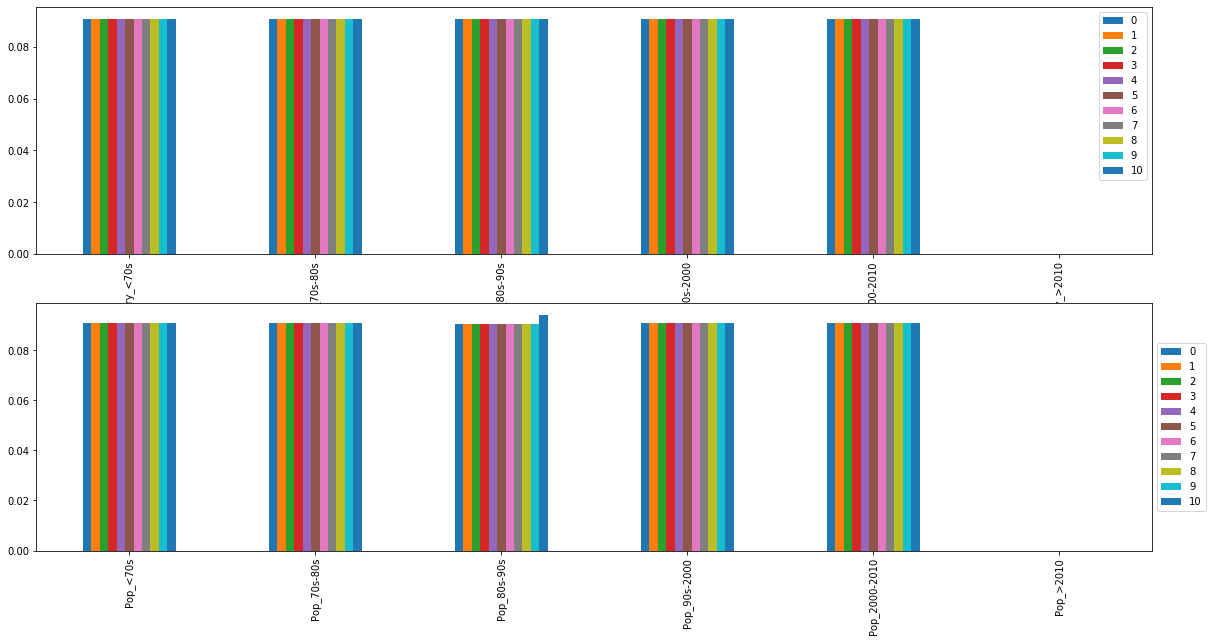

In [81]:
lyrics_author_lda.plot_aggregated_topics(include_genres=["Country", "Pop"], fig_size=(20, 10))

In [82]:
test = pd.DataFrame.from_dict({"a":[10,20,30,40,50,60], "b":[1,1,2,2,1,2], "c":[3,4,4,3,3,4]})
test

,a,b,c
0,10,1,3
1,20,1,4
2,30,2,4
3,40,2,3
4,50,1,3
5,60,2,4


In [83]:
grouped = test.groupby(["b", "c"])

In [84]:
keys = list(grouped.groups.keys())
keys

[(1, 3), (1, 4), (2, 3), (2, 4)]

In [85]:
grouped = grouped.mean()
grouped

a
b c    
1 3  30
  4  20
2 3  40
  4  45

In [96]:
grouped.loc[1, "a"][[4,3]]

c
4    20
3    30
Name: a, dtype: int64

In [9]:
random.seed(7)

In [17]:
ciao = [1,2,3,4,5,6]
random.shuffle(ciao)

In [18]:
ciao

[2, 3, 4, 6, 5, 1]